In [1]:
import math
import torch
from torch import nn
import numpy as np
from datasets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 启用CUDA加速

In [2]:
class My_legacyLSTM(nn.Module):
    def _init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_f = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_f = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.w_i = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_i = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.w_o = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_o = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.w_c = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_c = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 需要初始化隐藏状态和细胞状态
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            forget_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_f) +
                                       torch.matmul(h, self.u_f) + self.b_f)
            # (batch_siz,hidden_size)
            input_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_i) +
                                      torch.matmul(h, self.u_i) + self.b_i)
            output_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_o) +
                                       torch.matmul(h, self.u_o) + self.b_o)
            # 这里可以看到各个门的运作方式。
            # 三个门均通过hadamard积作用在每一个维度上。
            c = forget_gate * c + input_gate * self.tanh(torch.matmul(x[:, i, :], self.w_c) +
                                                         torch.matmul(h, self.u_c) + self.b_c)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

In [3]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [4]:
# 读取数据
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 256
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
input_size = train_set.X.shape[-1]
hidden_size = 6
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 30
loss_func = nn.MSELoss()
my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_lstm.parameters(), lr)

In [5]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [6]:
from utils import *
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)

*** epoch1, train loss 0.0179, train rmse 152.5212, val loss 0.0128, val rmse 126.996786, time use 15.120s
*** epoch2, train loss 0.0075, train rmse 94.8372, val loss 0.0016, val rmse 43.789778, time use 14.875s
*** epoch3, train loss 0.0013, train rmse 41.3652, val loss 0.0011, val rmse 37.086894, time use 14.262s
*** epoch4, train loss 0.0011, train rmse 37.1597, val loss 0.0010, val rmse 34.427590, time use 14.400s
*** epoch5, train loss 0.0010, train rmse 35.3855, val loss 0.0009, val rmse 32.896638, time use 14.356s
*** epoch6, train loss 0.0009, train rmse 34.1892, val loss 0.0009, val rmse 31.876084, time use 14.444s
*** epoch7, train loss 0.0008, train rmse 33.1796, val loss 0.0008, val rmse 30.865357, time use 14.320s
*** epoch8, train loss 0.0008, train rmse 32.2422, val loss 0.0008, val rmse 29.952499, time use 14.734s
*** epoch9, train loss 0.0008, train rmse 31.4379, val loss 0.0007, val rmse 29.177814, time use 14.437s
*** epoch10, train loss 0.0007, train rmse 30.7123, v

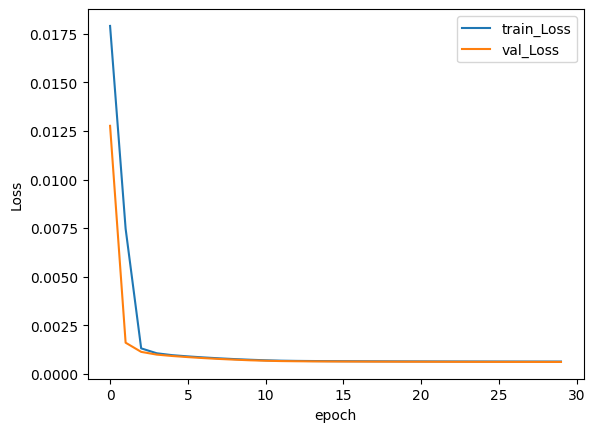

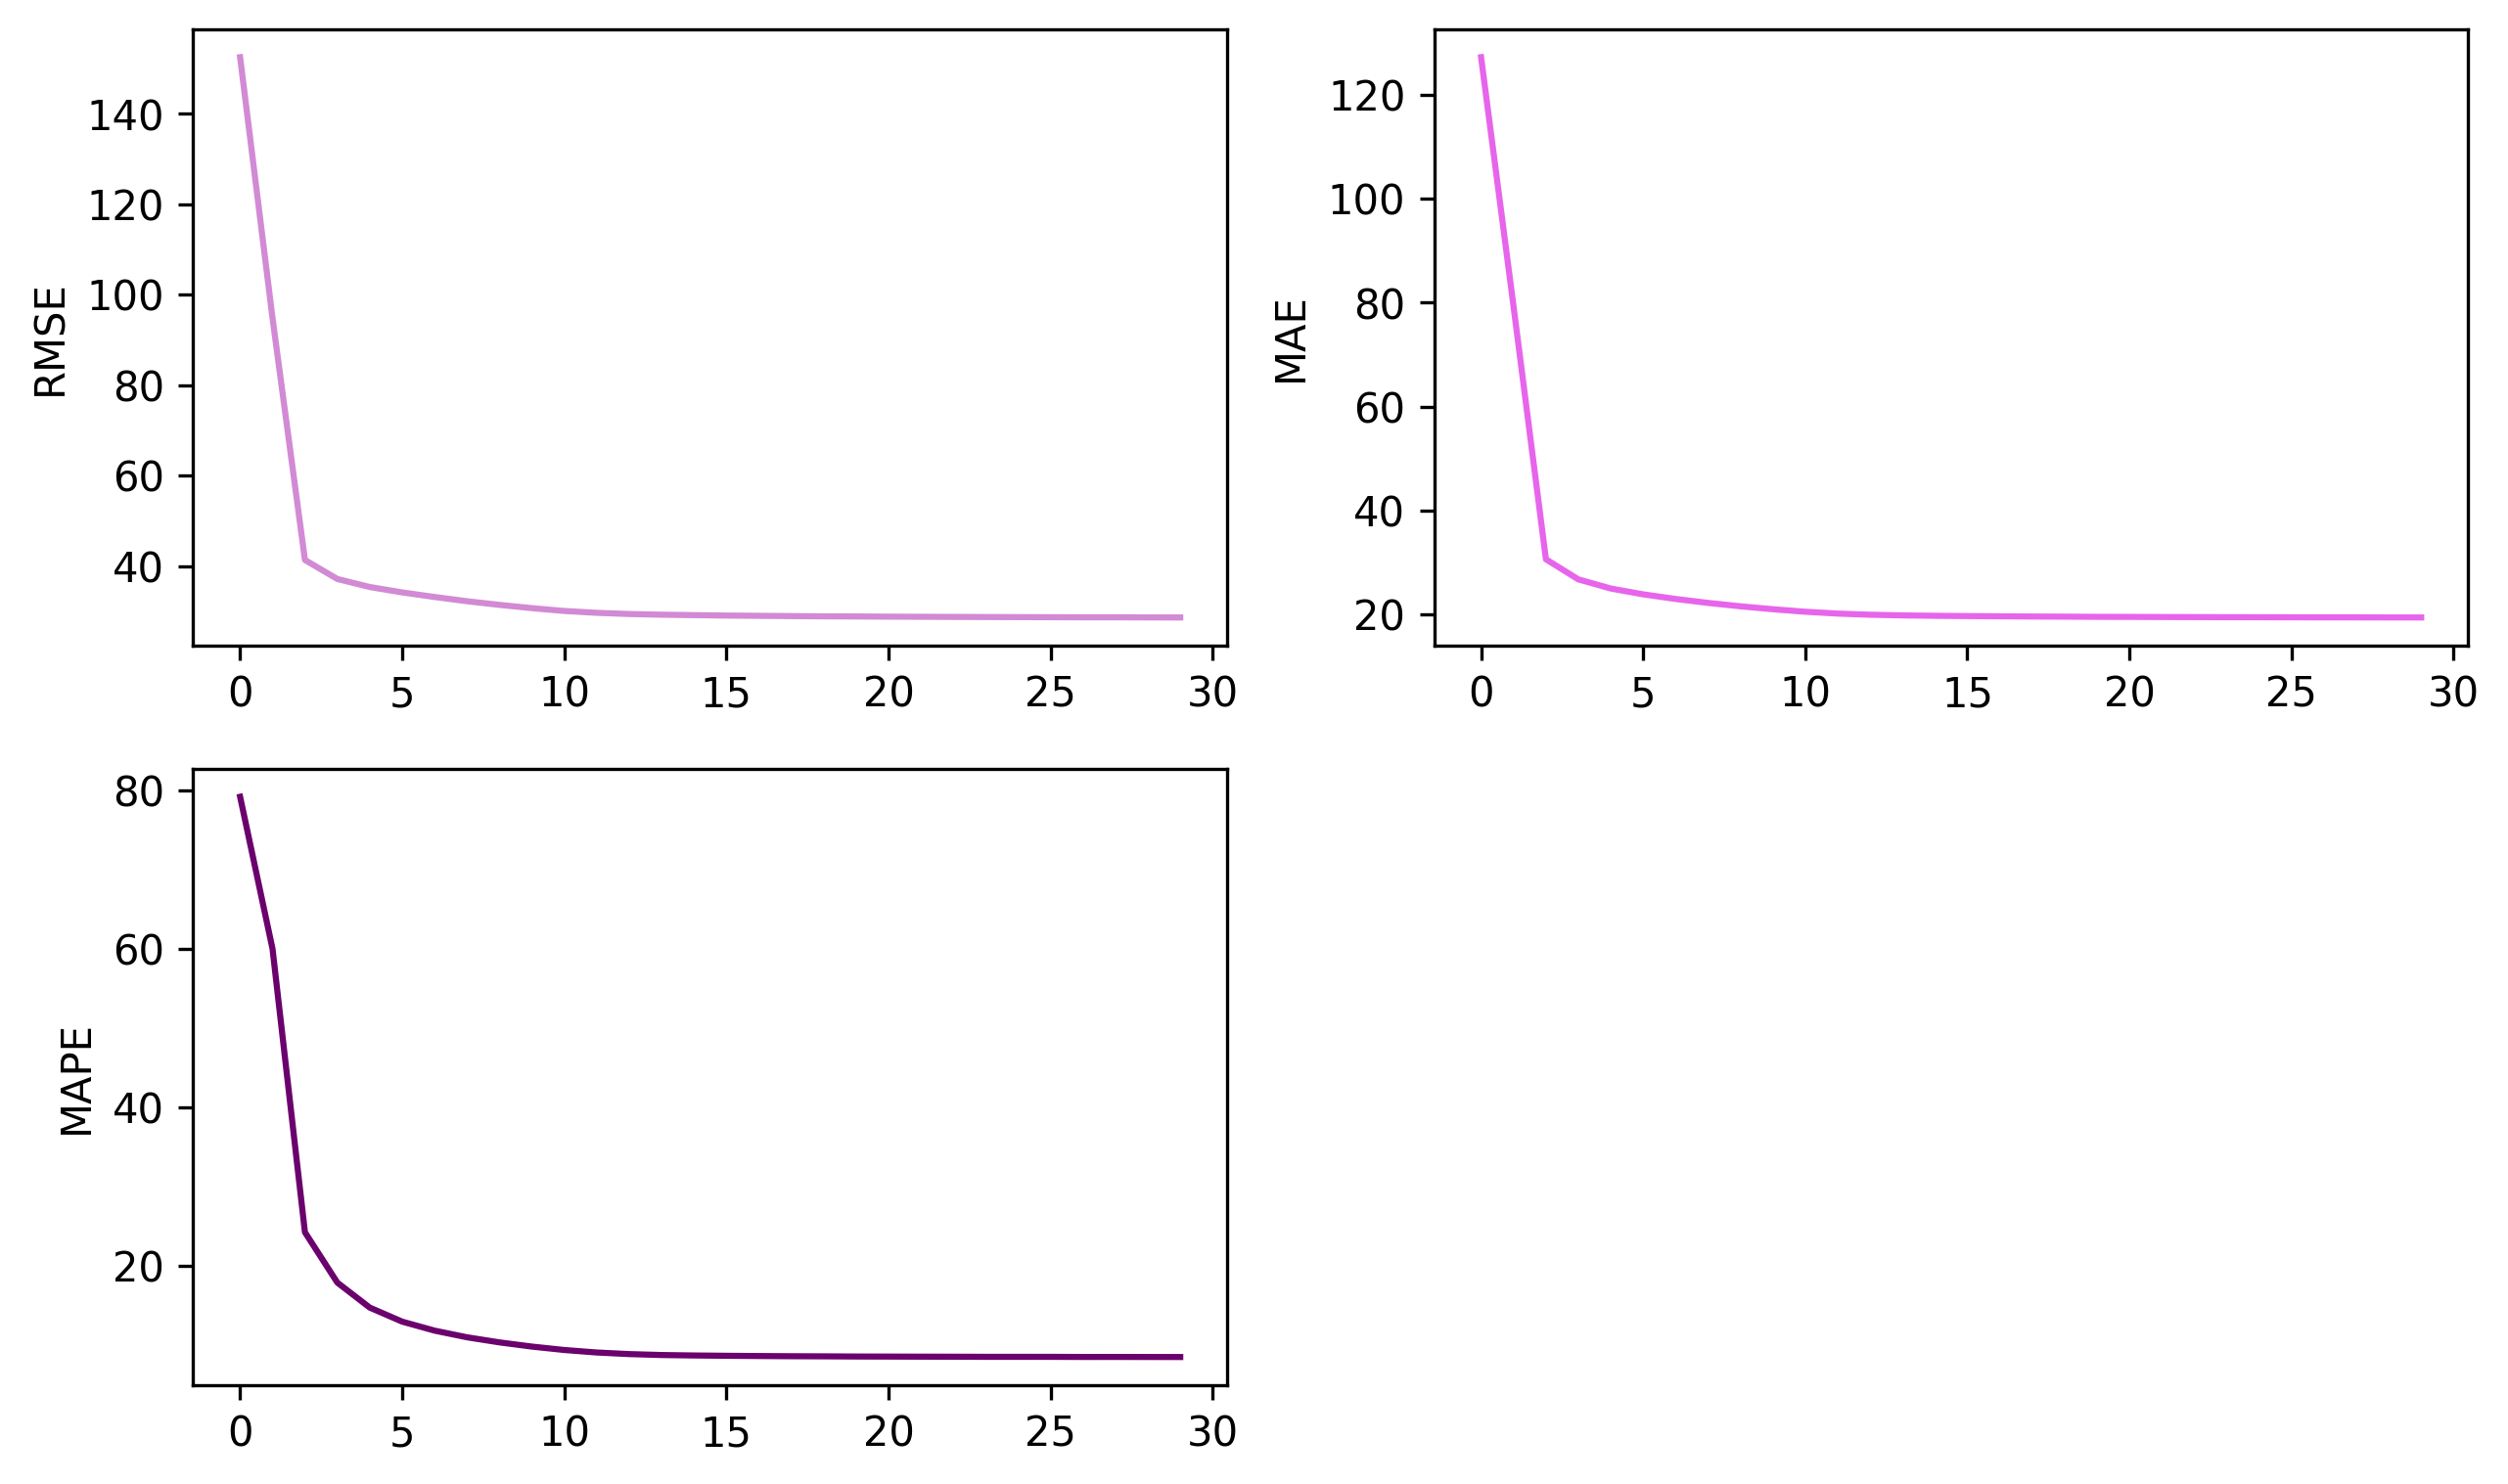

In [7]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [8]:
# 超参数对比
hidden_size = 16 # 对比hidden_size
my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_lstm.parameters(), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)
lr = 0.001 # 对比lr
hidden_size = 6 
my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_lstm.parameters(), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)

*** epoch1, train loss 0.0058, train rmse 74.9997, val loss 0.0009, val rmse 32.677424, time use 14.856s
*** epoch2, train loss 0.0009, train rmse 33.7419, val loss 0.0008, val rmse 31.255484, time use 14.336s
*** epoch3, train loss 0.0008, train rmse 32.6080, val loss 0.0008, val rmse 30.114896, time use 14.217s
*** epoch4, train loss 0.0008, train rmse 31.6461, val loss 0.0007, val rmse 29.488349, time use 14.391s
*** epoch5, train loss 0.0007, train rmse 30.8107, val loss 0.0007, val rmse 28.635755, time use 14.958s
*** epoch6, train loss 0.0007, train rmse 30.0977, val loss 0.0007, val rmse 28.016337, time use 14.162s
*** epoch7, train loss 0.0007, train rmse 29.5443, val loss 0.0006, val rmse 27.677800, time use 14.297s
*** epoch8, train loss 0.0007, train rmse 29.1934, val loss 0.0006, val rmse 27.280723, time use 14.439s
*** epoch9, train loss 0.0006, train rmse 28.9700, val loss 0.0006, val rmse 27.129503, time use 14.073s
*** epoch10, train loss 0.0006, train rmse 28.8414, val

In [9]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 6
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 30
loss_func = nn.MSELoss()

nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)

*** epoch1, train loss 0.0223, train rmse 171.0043, val loss 0.0185, val rmse 152.638561, time use 2.971s
*** epoch2, train loss 0.0147, train rmse 137.4078, val loss 0.0046, val rmse 75.861823, time use 2.470s
*** epoch3, train loss 0.0016, train rmse 44.5008, val loss 0.0012, val rmse 37.934748, time use 2.497s
*** epoch4, train loss 0.0012, train rmse 39.5652, val loss 0.0012, val rmse 36.373013, time use 2.509s
*** epoch5, train loss 0.0011, train rmse 38.1950, val loss 0.0011, val rmse 35.140728, time use 2.527s
*** epoch6, train loss 0.0010, train rmse 36.8169, val loss 0.0010, val rmse 33.996564, time use 2.688s
*** epoch7, train loss 0.0010, train rmse 35.4394, val loss 0.0009, val rmse 32.797222, time use 2.493s
*** epoch8, train loss 0.0009, train rmse 34.1437, val loss 0.0009, val rmse 31.544176, time use 2.469s
*** epoch9, train loss 0.0008, train rmse 32.9589, val loss 0.0008, val rmse 30.401124, time use 2.305s
*** epoch10, train loss 0.0008, train rmse 31.9068, val loss 

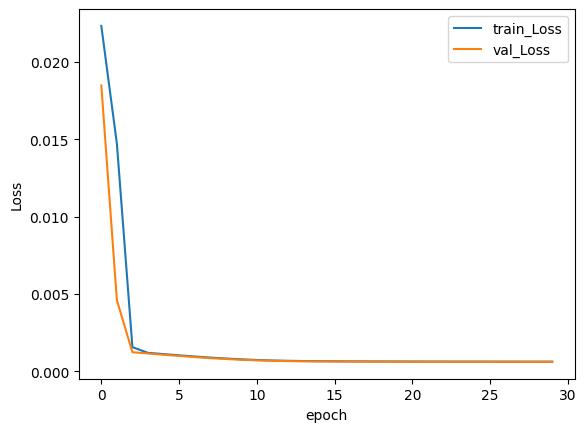

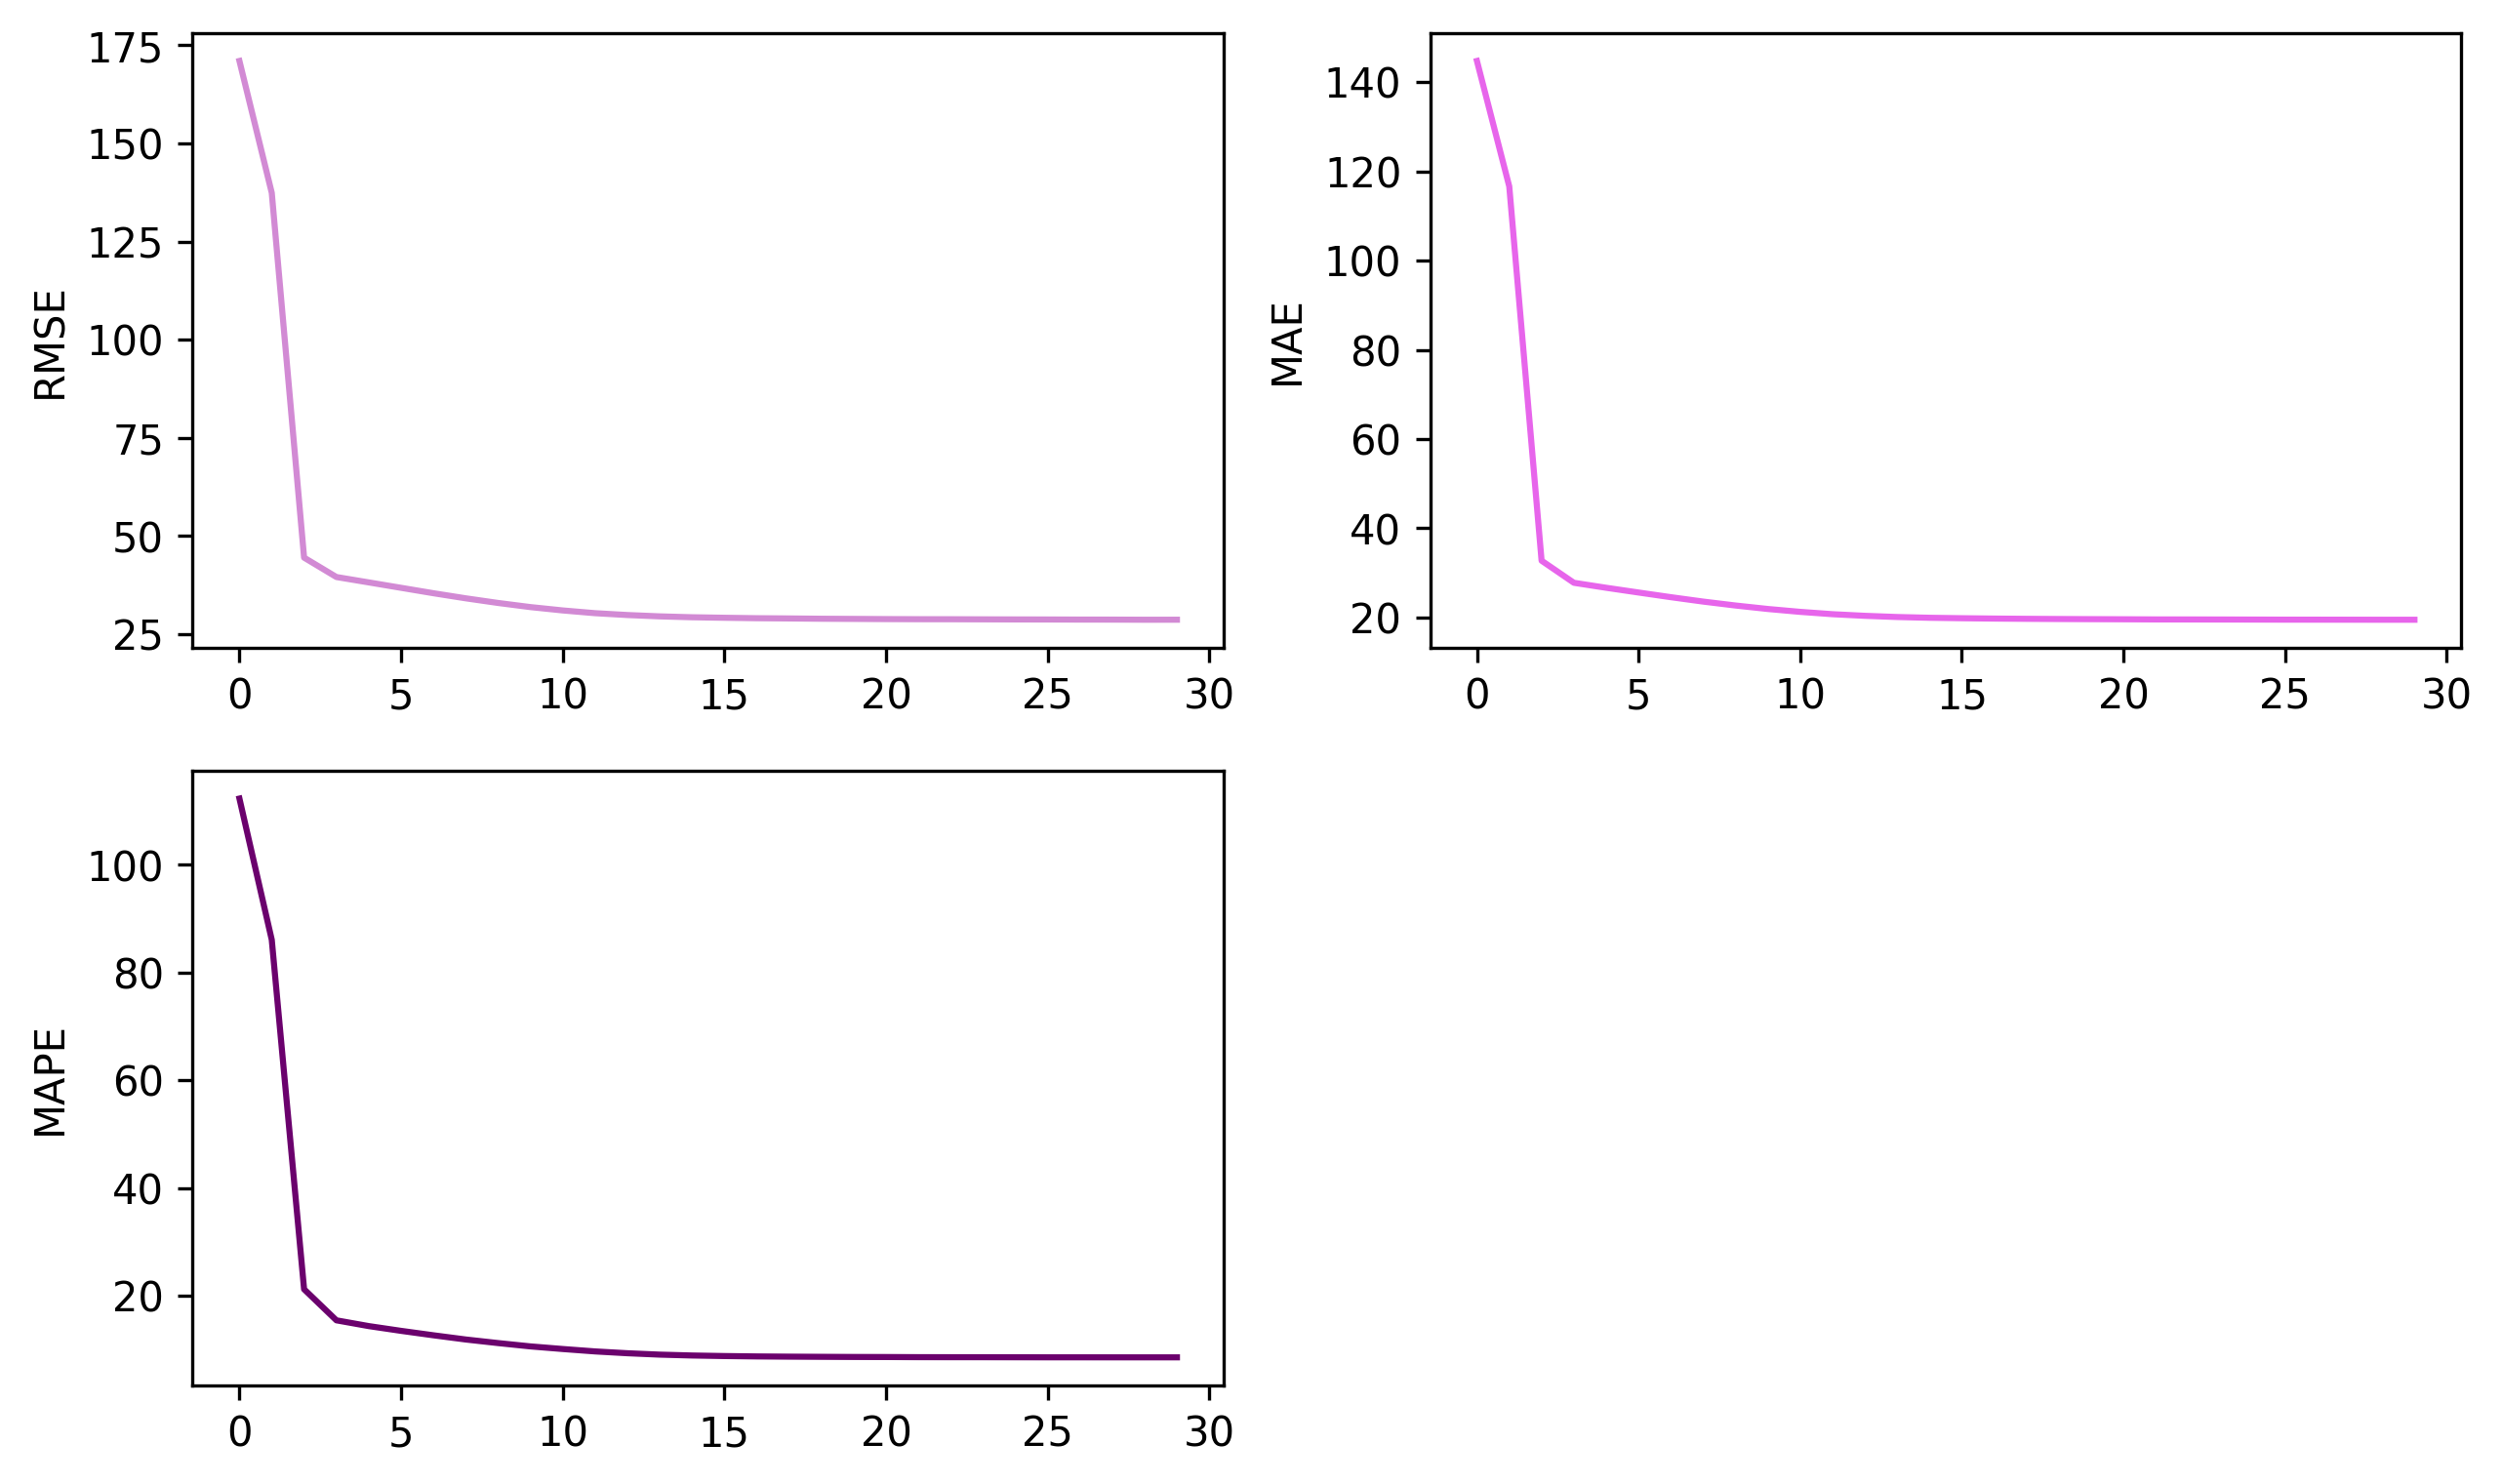

In [10]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [11]:
# 超参数对比
hidden_size = 16 # 对比hidden_size
nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)
optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)
hidden_size = 6
lr = 0.001 #对比lr
nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)
optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)

*** epoch1, train loss 0.0224, train rmse 167.4830, val loss 0.0110, val rmse 117.690148, time use 2.889s
*** epoch2, train loss 0.0031, train rmse 58.2651, val loss 0.0014, val rmse 39.613757, time use 2.631s
*** epoch3, train loss 0.0013, train rmse 41.4262, val loss 0.0013, val rmse 38.115451, time use 2.567s
*** epoch4, train loss 0.0012, train rmse 40.0997, val loss 0.0012, val rmse 36.821729, time use 2.780s
*** epoch5, train loss 0.0011, train rmse 38.5869, val loss 0.0011, val rmse 35.222061, time use 2.514s
*** epoch6, train loss 0.0010, train rmse 36.9509, val loss 0.0010, val rmse 33.665543, time use 2.511s
*** epoch7, train loss 0.0010, train rmse 35.2315, val loss 0.0009, val rmse 32.387574, time use 2.624s
*** epoch8, train loss 0.0009, train rmse 33.5819, val loss 0.0008, val rmse 30.676133, time use 2.612s
*** epoch9, train loss 0.0008, train rmse 32.0255, val loss 0.0007, val rmse 29.366625, time use 2.603s
*** epoch10, train loss 0.0007, train rmse 30.8155, val loss 0